In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

dataset_name = "music4all"
dataset_relative_location = "../../../dataset"

dataset_path = Path(dataset_relative_location) / dataset_name

datasets = {}

csvsPattern = "*.csv"
csvs = list(dataset_path.glob(csvsPattern))
csvs

for csv in csvs:
    datasets[csv.stem] = pd.read_csv(csv, delimiter="\t")

# Taking a look at the datasets we have
datasets.keys()
sns.set_theme()

In [2]:
listening_history = datasets["listening_history"].copy(deep=True)
listening_history.head()

,user,song,timestamp
0,user_007XIjOr,DaTQ53TUmfP93FSr,2019-02-20 12:28
1,user_007XIjOr,dGeyvi5WCOjDU7da,2019-02-20 12:35
2,user_007XIjOr,qUm54NYOjeFhmKYx,2019-02-20 12:48
3,user_007XIjOr,FtnuMT1DlevSR2n5,2019-02-20 12:52
4,user_007XIjOr,LHETTZcSZLeaVOGh,2019-02-20 13:09


In [3]:
listening_history.describe()

,user,song,timestamp
count,5109592,5109592,5109592
unique,14127,99596,122340
top,user_laAIutaN,32m5suoC94ytD8Ed,2019-02-08 20:35
freq,500,82871,175


In [4]:
all_users_history = listening_history.copy(deep=True)
all_users_history["timestamp"] = pd.to_datetime(all_users_history["timestamp"])

In [5]:
user_history = listening_history.query("user == 'user_007XIjOr'").sort_values(by=["timestamp"])

In [6]:
user_history["timestamp"] = pd.to_datetime(user_history["timestamp"])

In [7]:
user_history["time_diff"] = user_history["timestamp"].diff().dt.seconds.div(60, fill_value=0)

In [8]:
def get_cdf(df, field='time_diff'):
    res = {}
    for quantile in np.arange(0.0, 1,0.0005):
        res[quantile] = df[field].quantile(quantile)
    res_series = pd.DataFrame(pd.Series(res)).reset_index().set_index(0)
    return res_series

## Entendendo quanto tempo é uma sessão do usuário

Ordenando por usuario e timestamp, calculando a diferença em minutos

In [9]:
sorted_user_history = all_users_history.sort_values(by=["user", "timestamp"])
sorted_user_history["new_user"] = sorted_user_history.user != sorted_user_history.user.shift()
sorted_user_history["time_diff"] = sorted_user_history["timestamp"].diff().dt.seconds.div(60, fill_value=0)
sorted_user_history.loc[sorted_user_history.new_user] = None

In [10]:
sorted_user_history = sorted_user_history.dropna()

In [11]:
time_diff_all_users = get_cdf(sorted_user_history)

<AxesSubplot:xlabel='0'>

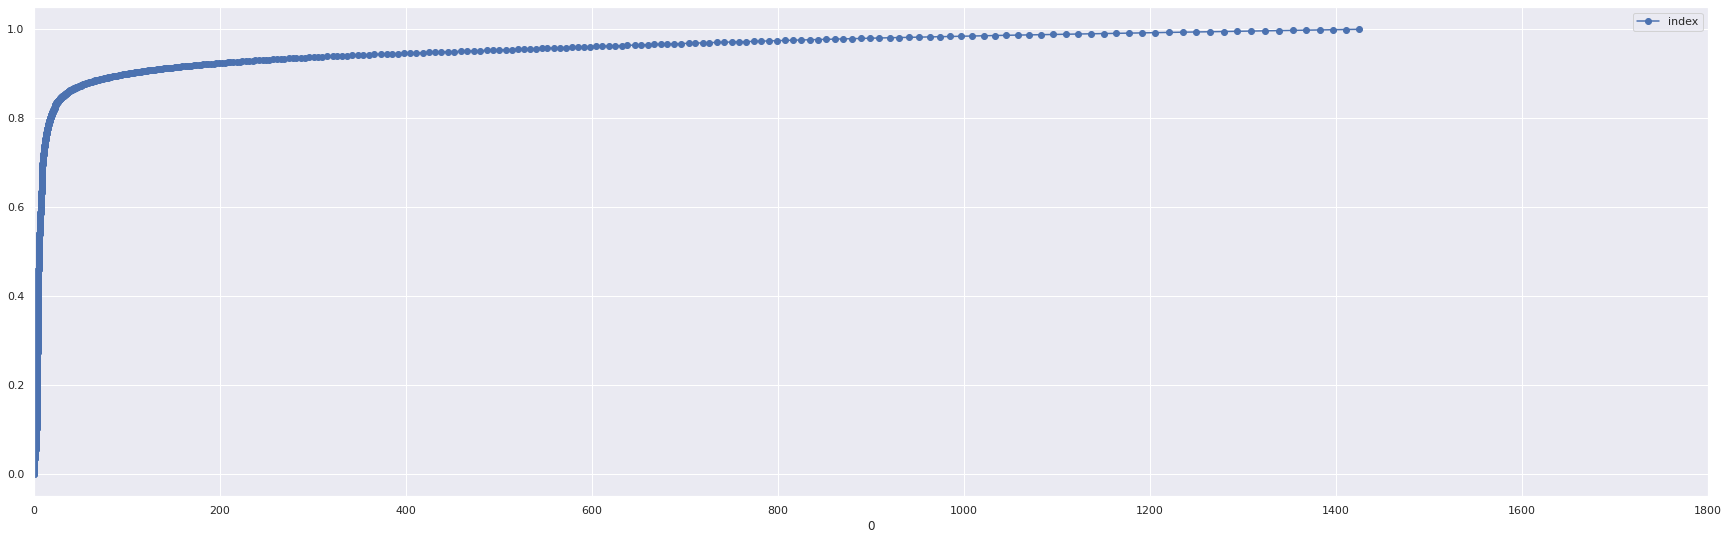

In [32]:
time_diff_all_users.plot(marker='o', figsize=(30,9), xlim=(0,1800))

Na maioria das vezes uma sessão de um usuário é de 101 minutos

In [12]:
sorted_user_history

,user,song,timestamp,new_user,time_diff
1,user_007XIjOr,dGeyvi5WCOjDU7da,2019-02-20 12:35:00,0.0,7.0
2,user_007XIjOr,qUm54NYOjeFhmKYx,2019-02-20 12:48:00,0.0,13.0
3,user_007XIjOr,FtnuMT1DlevSR2n5,2019-02-20 12:52:00,0.0,4.0
4,user_007XIjOr,LHETTZcSZLeaVOGh,2019-02-20 13:09:00,0.0,17.0
5,user_007XIjOr,LHETTZcSZLeaVOGh,2019-02-20 13:13:00,0.0,4.0
...,...,...,...,...,...
5109587,user_zzWscYTy,BBiswLufo26YQCT7,2019-01-10 15:57:00,0.0,9.0
5109588,user_zzWscYTy,5ZHgff3sjETIiedr,2019-01-10 16:21:00,0.0,24.0
5109589,user_zzWscYTy,m4O1iLh6fC43xjRy,2019-01-10 16:48:00,0.0,27.0
5109590,user_zzWscYTy,mvUaP8k67qOFfA65,2019-01-10 21:13:00,0.0,265.0


In [13]:
sessions = sorted_user_history.query("time_diff > 101").index.tolist()
new_users = all_users_history.user.ne(all_users_history.user.shift())[1:]
new_users = new_users.index[new_users == True].tolist()

stop_indexes = sessions + new_users

In [14]:
# Loading df with disruption
df_with_disruption = pd.read_csv(Path("../dataset") / "output" / "csv_with_disruption" / "song_info_with_disruption_26638_feat_transfer_learning_gamma_0.1.csv")
df_with_disruption = df_with_disruption.drop(columns=["Unnamed: 0", "index", "mapping_to_fv_index"])

In [17]:
ids_in_dataset = set(df_with_disruption["id"].to_list())

In [15]:
from tqdm import tqdm

In [18]:
start_index = 0
end_index = 0
user_listening_history_as_clickstream = []

for index, num in tqdm(enumerate(stop_indexes)):
    song_session = sorted_user_history["song"].loc[start_index:num].to_list()
    
    # checking if at least one song in the song session is in the  dataset
    song_in_dataset = False

    for song in song_session:
        if song in ids_in_dataset:
            song_in_dataset = True
            break
    
    if not song_in_dataset:
        continue

    user_listening_history_as_clickstream.append(song_session)
    start_index = num


522795it [01:23, 6278.86it/s]


In [20]:
len(user_listening_history_as_clickstream)

189178

In [28]:
import random

cut_entries = user_listening_history_as_clickstream[:2000]
random.shuffle(cut_entries)
cut_entries

[['E97YQe8PEngwKnWJ',
  'lEHWWZF9FRdjq0xq',
  'cJoPnSodd3SNcwLe',
  'xkQHIa7i5Eq3IlAw',
  '0Lgc4YsFJTKIOTZQ'],
 ['Nia1LzopIDdpp9Xs',
  'O7e09bhxzTnddz4d',
  'O7e09bhxzTnddz4d',
  'O7e09bhxzTnddz4d',
  'O7e09bhxzTnddz4d',
  'o7HlDgE8t1LPGNvh',
  'o7HlDgE8t1LPGNvh',
  'o7HlDgE8t1LPGNvh',
  'jznaBggs140GlHGH',
  'wNFa9zt0pAOC8pRJ',
  'tqJvL8UbtN4TEMBy',
  'y15PxmDsr87Ul3AB',
  'qq5vzfzinhePpehj',
  'doUiLcUAhLqrvC2Q',
  'DotApFAX3PFSdn6E',
  '0dnPjIfjqpFLPYIl',
  'YfRACunB4Qsbf8tY',
  'XMVsifKgldTqJs57',
  '9iRJtjMJFIapl5EW',
  'Gh4yUdMJrPrPAJjb',
  'KUE5rvYdgHDnKMFM'],
 ['326LMSn4SJdPnm1d',
  '0WMcjLENc3JlYAPw',
  'i6eRQgNB2UlIVUSw',
  '0Y5TcGlWJnW7IVdK',
  'DOzKgUJxPcShwygO'],
 ['aQgfcn3fxGvDikt7',
  'zTwcDYRdJqUg5oVB',
  'NsYB7VXoMIG7dsip',
  '0jP2q4c51hZRm8eK',
  '0jP2q4c51hZRm8eK',
  'fcsxlzLLCPwAWWIb',
  'GbFJjSVcklMSNsqQ',
  'fcsxlzLLCPwAWWIb',
  'Vl4H1Ll16dD1TDlO',
  'Vl4H1Ll16dD1TDlO',
  'wa3NcWiWGkXca2lW',
  'dBDGWf06sWOmFFMg',
  'suIwOp3QGS8mqm8w'],
 ['GP6V2MRYCZaiRNQ5', 'NCD8X

In [30]:
import csv
listening_history_file_path = Path("../analyzing_history") / f"cut_entries{len(cut_entries)}.ngram"

with open(listening_history_file_path, "w") as file:
    writer = csv.writer(file)
    writer.writerows(cut_entries)


In [20]:
import pathpy as pp

In [31]:
listening_history = pp.Paths.read_file(Path("../analyzing_history") / f"cut_entries2000.ngram", frequency=False, max_ngram_length=100)

2021-09-05 15:59:56 [Severity.INFO]	Reading ngram data ... 
2021-09-05 15:59:56 [Severity.INFO]	finished. Read 2000 paths with maximum length 99
2021-09-05 15:59:56 [Severity.INFO]	Calculating sub path statistics ... 
2021-09-05 16:08:19 [Severity.INFO]	finished.


In [32]:
print(listening_history)

Total path count: 		2000.0 
[Unique / Sub paths / Total]: 	[1999.0 / 1185741.0 / 1187741.0]
Nodes:				13993 
Edges:				33093
Max. path length:		99
Avg path length:		21.251 
Paths of length k = 0		0.0 [ 0.0 / 44502.0 / 44502.0 ]
Paths of length k = 1		135.0 [ 134.0 / 42367.0 / 42502.0 ]
Paths of length k = 2		143.0 [ 143.0 / 40359.0 / 40502.0 ]
Paths of length k = 3		113.0 [ 113.0 / 38524.0 / 38637.0 ]
Paths of length k = 4		100.0 [ 100.0 / 36815.0 / 36915.0 ]
Paths of length k = 5		105.0 [ 105.0 / 35201.0 / 35306.0 ]
Paths of length k = 6		89.0 [ 89.0 / 33708.0 / 33797.0 ]
Paths of length k = 7		78.0 [ 78.0 / 32315.0 / 32393.0 ]
Paths of length k = 8		84.0 [ 84.0 / 30994.0 / 31078.0 ]
Paths of length k = 9		60.0 [ 60.0 / 29781.0 / 29841.0 ]
Paths of length k = 10		72.0 [ 72.0 / 28616.0 / 28688.0 ]
Paths of length k = 11		56.0 [ 56.0 / 27539.0 / 27595.0 ]
Paths of length k = 12		51.0 [ 51.0 / 26523.0 / 26574.0 ]
Paths of length k = 13		50.0 [ 50.0 / 25559.0 / 25609.0 ]
Paths of length k

In [46]:
max_order = 2

mog = pp.MultiOrderModel(listening_history, max_order)
order = mog.estimate_order()

2021-09-05 18:39:51 [Severity.INFO]	Generating 0-th order layer ...
2021-09-05 18:42:10 [Severity.INFO]	Generating 1-th order layer ...
2021-09-05 18:42:13 [Severity.INFO]	Generating 2-th order layer ...
2021-09-05 18:42:19 [Severity.INFO]	finished.
2021-09-05 18:42:29 [Severity.INFO]	Likelihood ratio test for K_opt = 2, x = 88646.43518022279
2021-09-05 18:42:29 [Severity.INFO]	Likelihood ratio test, d_1-d_0 = 230179
2021-09-05 18:42:29 [Severity.INFO]	Likelihood ratio test, p = 1.0


In [48]:
print(mog.layers[2])

Higher-order network of order k = 2

Nodes:				33093
Links:				35144
Total weight (subpaths/longest paths):	40359.0/143.0



In [40]:
pr = pp.algorithms.centralities.pagerank(mog.layers[2])

In [44]:
dict(sorted(pr.items(), key=lambda item: item[1], reverse=True))


{'32m5suoC94ytD8Ed': 0.008649161267246854,
 'vkOg9ZAiUgUT87k6': 0.0032971415184254228,
 'Pf7CTDMAqnLhbcY2': 0.002596178720164225,
 'KKmk2QJLVj2Aqsjg': 0.002559036546985703,
 'YwURIu6eZDCJyuEf': 0.002407641347664748,
 'e8SzjFTY8PQsuSv9': 0.0019202240076126773,
 'YhuXZBiCxjMR4FfQ': 0.001899725159644516,
 '3shrACNQQ5eeQEAO': 0.001653377514508574,
 'EBB7mUheKyVbv6OI': 0.0016367627415860388,
 '7Gsb7yKtAJNCvWez': 0.0015398263626797374,
 'xMkeAOwn6AzEeYGh': 0.0015013045881276674,
 'AYxLbkF55hvueDLM': 0.0014662511892779106,
 'FuVju35v7B0jtKeU': 0.001404768326076708,
 '6YdzDwnoQ34wZoyv': 0.0014026441158352517,
 '8LgQbYbM6Vz2my0y': 0.0013496668841712202,
 'kQYKOpACJ7CUOZVr': 0.0012982503083444384,
 '7PX1VlK5HWCGAoFE': 0.0012926098202888391,
 'cU7wXxFv0vUJTZwr': 0.001251468751852595,
 'a4CorjFKnUQhzVSs': 0.0011610281811444594,
 'TcUb75QrVdYnF7Jo': 0.0011322336522722899,
 'LPDMx981Xn1Hpmrz': 0.001081403628803113,
 '4Ftif9qQReU76eG4': 0.0010704310236343854,
 'Yr0aRxN7lGaLH3xF': 0.001035161270063843

In [45]:
from markovclick.preprocessing import Sessionise



In [ ]:
sessioniser = Sessionise(df, unique_id_col='cookie_id',
			 datetime_col='timestamp', session_timeout=30)